# Iteration 3: Including categorical data using one-hot encoding

## Modules

In [163]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
sklearn.set_config(transform_output='pandas')

## Import data

In [164]:
raw_df = pd.read_csv('../data/housing_iteration_3_classification/housing_iteration_3_classification.csv')
raw_df

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,62.0,953,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1456,13175,85.0,1542,3,2,0,2,349,0,0,RL,Norm,GasA,Pave,Y,CBlock
1457,9042,66.0,1152,4,2,0,1,0,0,1,RL,Norm,GasA,Pave,Y,Stone
1458,9717,68.0,1078,2,0,0,1,366,0,0,RL,Norm,GasA,Pave,Y,CBlock


Split off labels:

In [165]:
X = raw_df.copy()
y = X.pop('Expensive')

Split into training vs. test set:

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
len(X_train), len(X_test), len(y_train), len(y_test)

(1168, 292, 1168, 292)

In [167]:
X_train.describe(include='all')

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
count,1168.000000,963.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168,1168,1168,1168,1168,1168
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9,5,2,2,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RL,Norm,GasA,Pave,Y,CBlock
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,919,1011,1143,1162,1088,511
mean,10343.374144,69.926272,1057.659247,2.875856,0.608733,1.851027,1.770548,95.279966,15.529110,NaN,NaN,NaN,NaN,NaN,NaN
std,8543.753911,23.213906,420.963908,0.808587,0.640126,31.626896,0.750040,124.220826,57.279431,NaN,NaN,NaN,NaN,NaN,NaN
min,1300.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,7572.750000,59.000000,796.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,9544.500000,68.000000,994.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,11601.500000,80.000000,1297.250000,3.000000,1.000000,0.000000,2.000000,168.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


_LotFrontage_ has some missing rows.

## Handle categorical data

In [168]:
cat_columns = X.select_dtypes(exclude=['number']).columns
cat_columns

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object')

In [169]:
num_columns = X.select_dtypes(include=['number']).columns
num_columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')

In [170]:
cat_pipe = make_pipeline(
  SimpleImputer(strategy='constant', fill_value='unknown'),
  OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'),
)
num_pipe = SimpleImputer(strategy='mean')

preprocessor = make_column_transformer(
  (cat_pipe, cat_columns),
  #('drop', cat_columns),
  (num_pipe, num_columns)
)

## Approach: Grid search on decision tree model

In [171]:
model = DecisionTreeClassifier()
pipe = make_pipeline(preprocessor, model)

param_grid = {
    #'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'decisiontreeclassifier__min_impurity_decrease': [0, 0.005], #[0, 0.005, 0.01, 0.05, 0.1],
    'decisiontreeclassifier__max_depth': range(2, 12),
    'decisiontreeclassifier__min_samples_leaf': range(1, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(2, 40, 5),
    #'decisiontreeclassifier__criterion':['gini', 'entropy']
}

search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        refit=True,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
)
search.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_s

[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=7, decisiontreeclassifier__min_samples_split=7; total time=   0.1s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=7, decisiontreeclassifier__min_samples_split=37; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=9, decisiontreeclassifier__min_samples_split=2; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=7, decisiontreeclassifier__min_samples_split=22; total time=   0.0s
[CV] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_impurity_decrease=0, decisiontreeclassifier__min_samples_leaf=7, decisiontreeclassifier__min_samples_split=27; t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralA...
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(2, 12),
                         'decisiontreeclassifier__min_impurity_decrease': [0,
                                                                           0.005],
                         'decisiontreeclassifier__min_samples_leaf': range(1, 10, 2),
                         'decisiontreeclassifier__min_samples_split': range(2, 40, 5)},
             scoring='accuracy', verbose=2)

In [172]:
print(
        pd.DataFrame(search.cv_results_)
        .groupby(['param_decisiontreeclassifier__min_impurity_decrease'])
        [['mean_test_score']]
        .describe()
        .T
        .to_markdown()
)

|                              |          0.0 |        0.005 |
|:-----------------------------|-------------:|-------------:|
| ('mean_test_score', 'count') | 400          | 400          |
| ('mean_test_score', 'mean')  |   0.911751   |   0.912389   |
| ('mean_test_score', 'std')   |   0.00615241 |   0.00104158 |
| ('mean_test_score', 'min')   |   0.886127   |   0.910117   |
| ('mean_test_score', '25%')   |   0.910088   |   0.911826   |
| ('mean_test_score', '50%')   |   0.913521   |   0.912681   |
| ('mean_test_score', '75%')   |   0.915249   |   0.912681   |
| ('mean_test_score', 'max')   |   0.922086   |   0.914376   |


In [173]:
search.best_score_

0.9220864971937933

In [174]:
search.best_params_

{'decisiontreeclassifier__max_depth': 8,
 'decisiontreeclassifier__min_impurity_decrease': 0,
 'decisiontreeclassifier__min_samples_leaf': 7,
 'decisiontreeclassifier__min_samples_split': 37}

In [175]:
tree_columns = [ _[_.rfind('__')+2:] for _ in search.best_estimator_[1].feature_names_in_ ]
tree_columns

['MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Street_Grvl',
 'Street_Pave',
 'CentralAir_N',
 'CentralAir_Y',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'LotArea',
 'LotFrontage',
 'TotalBsmtSF',
 'BedroomAbvGr',
 'Fireplaces',
 'PoolArea',
 'GarageCars',
 'WoodDeckSF',
 'ScreenPorch']

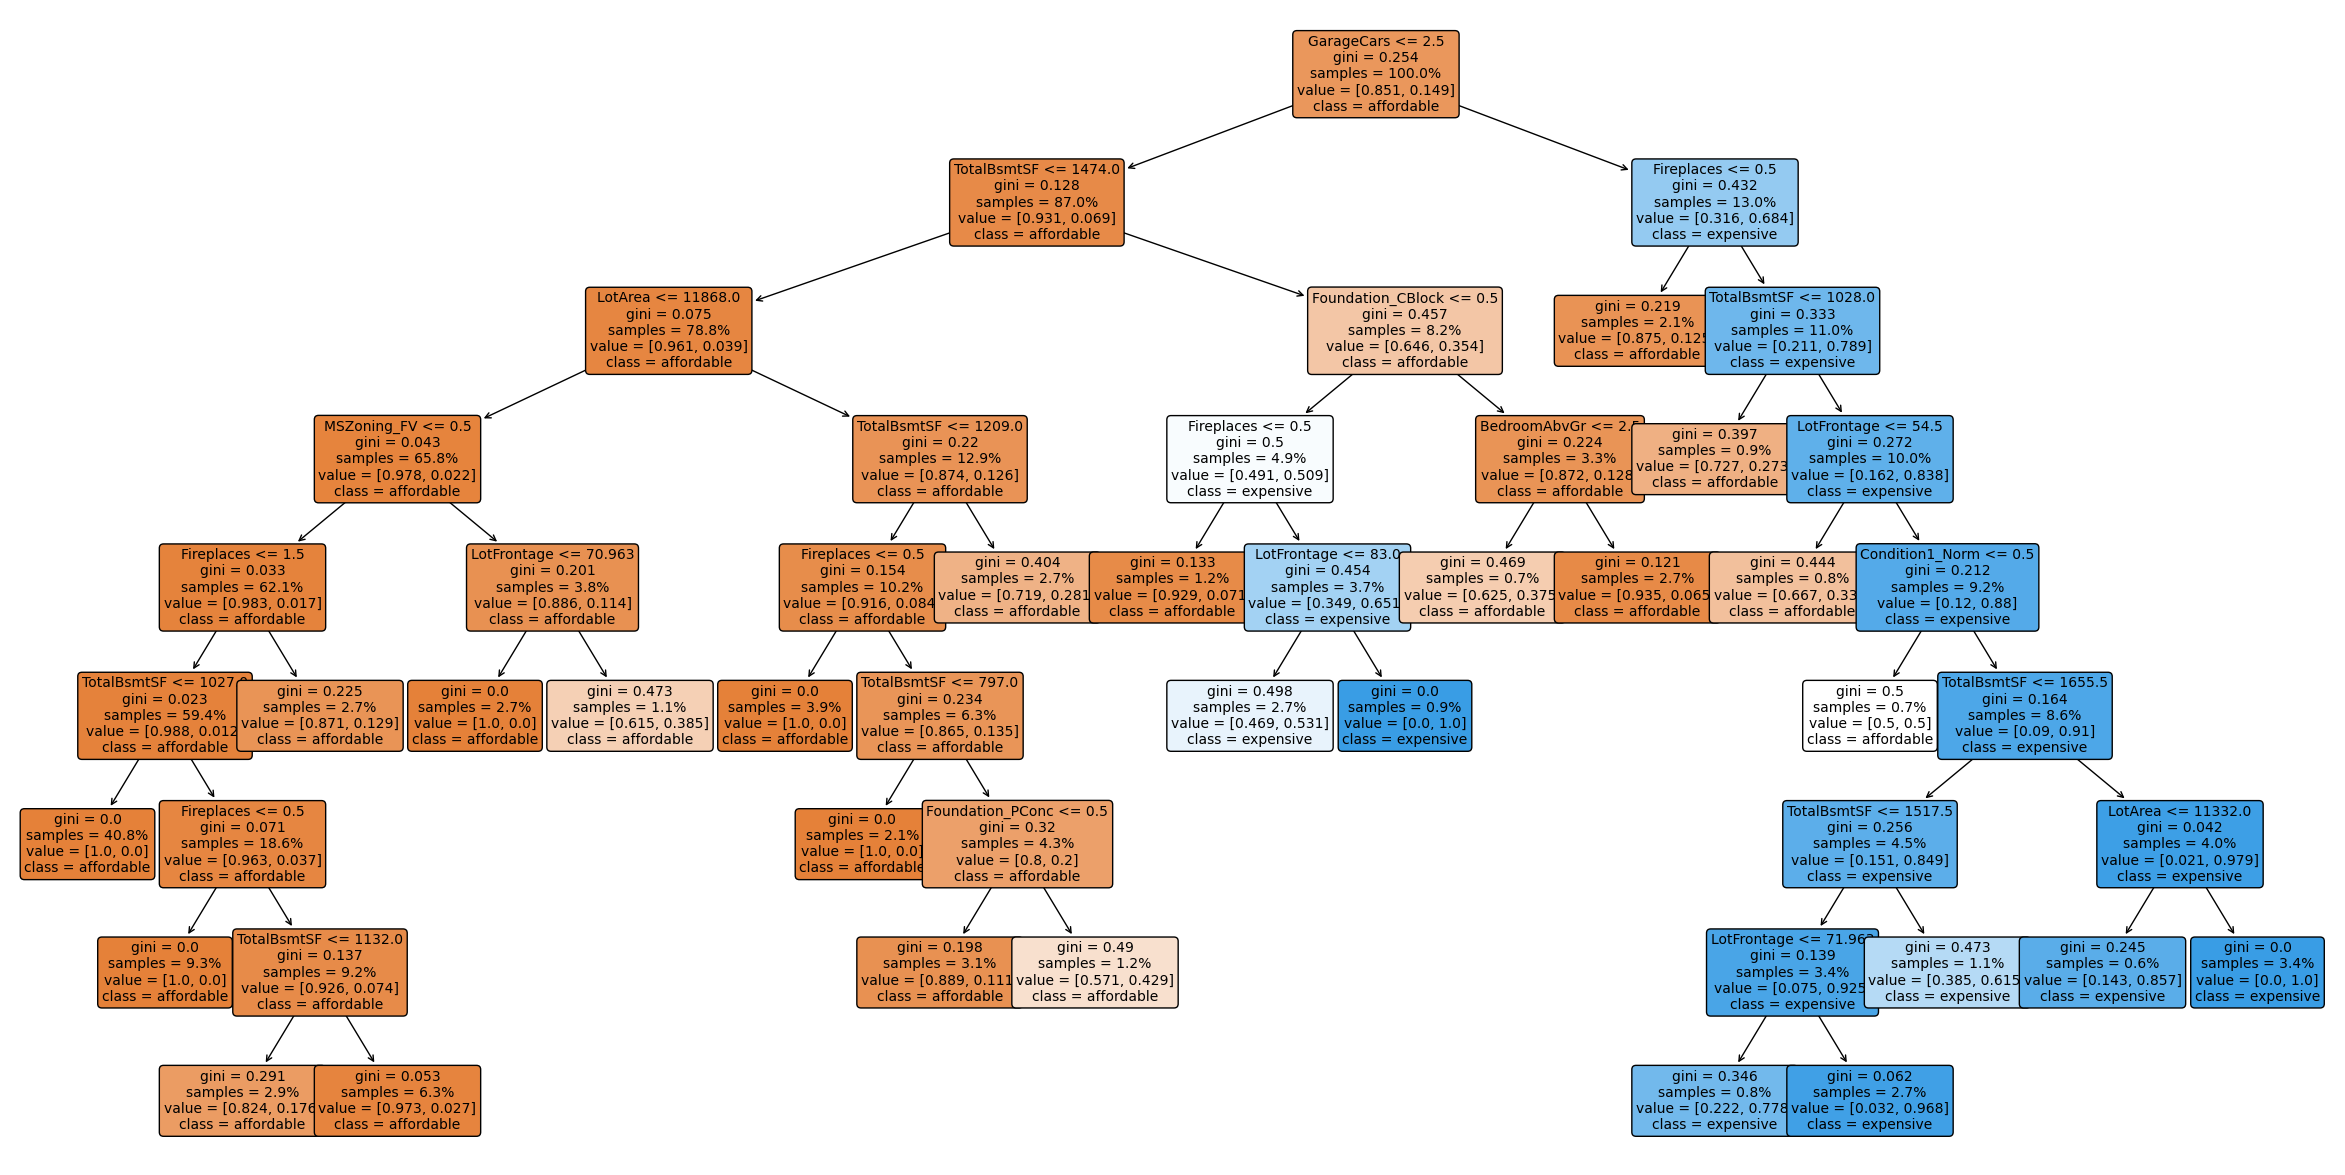

In [176]:
plt.figure(figsize=(30, 15))
plot_tree(search.best_estimator_[1], feature_names=tree_columns, class_names=['affordable', 'expensive'], proportion=True, rounded=True, filled=True, fontsize=10);

## Final scores

On training set:

In [177]:
accuracy_score(
  y_pred=search.predict(X_train),
  y_true=y_train)

0.9323630136986302

On test set:

In [178]:
accuracy_score(
  y_pred=search.predict(X_test),
  y_true=y_test)

0.9075342465753424

On complete set:

In [179]:
accuracy_score(
  y_pred=search.predict(X),
  y_true=y)

0.9273972602739726

## Dependence of training on test-fraction

It is important to note that depending on the random distribution of the labeled data-set into training- and test-set, the prediction quality varies. This can be characterized by splitting many times differently and recording accuracies. Doing this for different fractions between training- and test-set, gives the following plot:

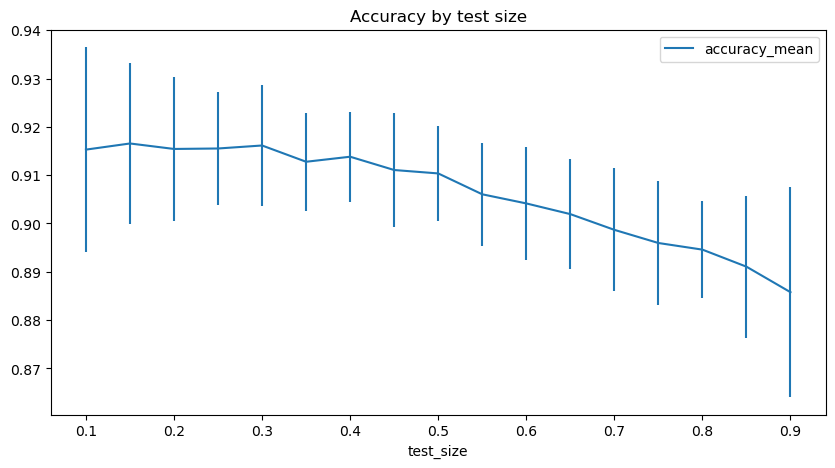

In [180]:
accuracies_by_test_size = pd.DataFrame(columns=['test_size', 'accuracy_mean', 'accuracy_std']).set_index('test_size')

for test_size in np.linspace(0.1, 0.9, 17):
  accuracies = []
  for i in range(100):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
      search.best_estimator_.fit(X=X_train, y=y_train)
      accuracies.append(accuracy_score(y_pred=search.predict(X_test), y_true=y_test))
  accuracies = pd.Series(accuracies)
  accuracies_by_test_size.loc[test_size] = [accuracies.mean(), accuracies.std()]

accuracies_by_test_size.plot(y='accuracy_mean', yerr='accuracy_std', figsize=(10, 5), title='Accuracy by test size');